# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# >🪴Selfnotes
## 🌿Focus on Training Data first
I learned that you need to focus first on making great predictions on training data before doing any validation. If your model sucks at Training data, then it will not be any better at your test data.

## 🌿Separate models for Linear Regression
If you do Linear regression on features that are unrelated with each other, you get weird stuff. The reason is Linear Regression assumes that a feature relates with another. Grocery items does not relate with Lipstick. So there should be no reason why we should use 1 to predict the other. This is why we create models separately. You can still do the pipeline prep on all of them but the models must be trained and predicted separately.

## 🌿Be better than the Average
Always starting by visualizing the target data with the average line. This is what you need to beat. From a straight line average to a wiggly line model predictions that is closely hug the target values.

## 🌿Fast Iteration
Let your mind go fast. Remove all friction and self-doubt. Just code and explore. Allow yourself to see your code as tools for discovery and experimentation, not a rigid framework.

In [1]:
from IPython.display import HTML

iframe_code = """
<iframe 
    width="900" height="700" 
    src="https://lookerstudio.google.com/embed/reporting/11c536c1-3cdd-4efd-b071-53ddf8b8edb4/page/8tZ1D" 
    frameborder="0" style="border:0" allowfullscreen 
    sandbox="
        allow-storage-access-by-user-activation 
        allow-scripts 
        allow-same-origin 
        allow-popups 
        allow-popups-to-escape-sandbox">
</iframe>
"""

display(HTML(iframe_code))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
## Clean
transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

oil['date'] = pd.to_datetime(oil['date'])
oil['inv_oil'] = 1/oil['dcoilwtico']
oil_price = dict(zip(oil['date'], oil['inv_oil']))

holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.query('transferred == False')
holidays['count'] = 1
holidays.groupby('date')['count'].max()
holidays = dict(zip(holidays['date'], holidays['count']))

def cleanData(a, st, oi, ho):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['month'] = a.date.dt.month
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_type'] = a['store_nbr'].map(st)
    a['oil_price'] = a['date'].map(oi)
    a['holidays'] = a['date'].map(ho)
    return a

df = cleanData(df, store_type, oil_price, holidays)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[~df['date'].dt.year.isin([2013, 2017])]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# > Understanding the Holidays
Ignore the transferred holidays because they were not celebrated on that day.

In [3]:
g = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
g['date'] = pd.to_datetime(g['date'])
g['weekname'] = pd.to_datetime(g['date']).dt.day_name()
g['month'] = g['date'].dt.month
g['year'] = g['date'].dt.year
g = g.query('transferred == False')
g['count'] = 1
g.groupby('date')['count'].max()

date
2012-03-02    1
2012-04-01    1
2012-04-12    1
2012-04-14    1
2012-04-21    1
2012-05-12    1
2012-06-23    1
2012-06-25    1
2012-07-03    1
2012-07-23    1
2012-08-05    1
2012-08-10    1
2012-08-15    1
2012-08-24    1
2012-09-28    1
2012-10-07    1
2012-10-12    1
2012-11-02    1
2012-11-03    1
2012-11-06    1
2012-11-07    1
2012-11-10    1
2012-11-11    1
2012-11-12    1
2012-12-05    1
2012-12-06    1
2012-12-08    1
2012-12-21    1
2012-12-22    1
2012-12-23    1
2012-12-24    1
2012-12-25    1
2012-12-26    1
2012-12-31    1
2013-01-01    1
2013-01-05    1
2013-01-12    1
2013-02-11    1
2013-02-12    1
2013-03-02    1
2013-04-01    1
2013-04-12    1
2013-04-14    1
2013-04-21    1
2013-04-29    1
2013-05-01    1
2013-05-11    1
2013-05-12    1
2013-05-24    1
2013-06-23    1
2013-06-25    1
2013-07-03    1
2013-07-23    1
2013-07-24    1
2013-07-25    1
2013-08-05    1
2013-08-10    1
2013-08-15    1
2013-08-24    1
2013-09-28    1
2013-10-07    1
2013-10-11    1
201

# > Beating the Average
If I just used the average, what would it look like? The model that I will build must be better than the average. What the hell is the point if I cannot be better than the average.

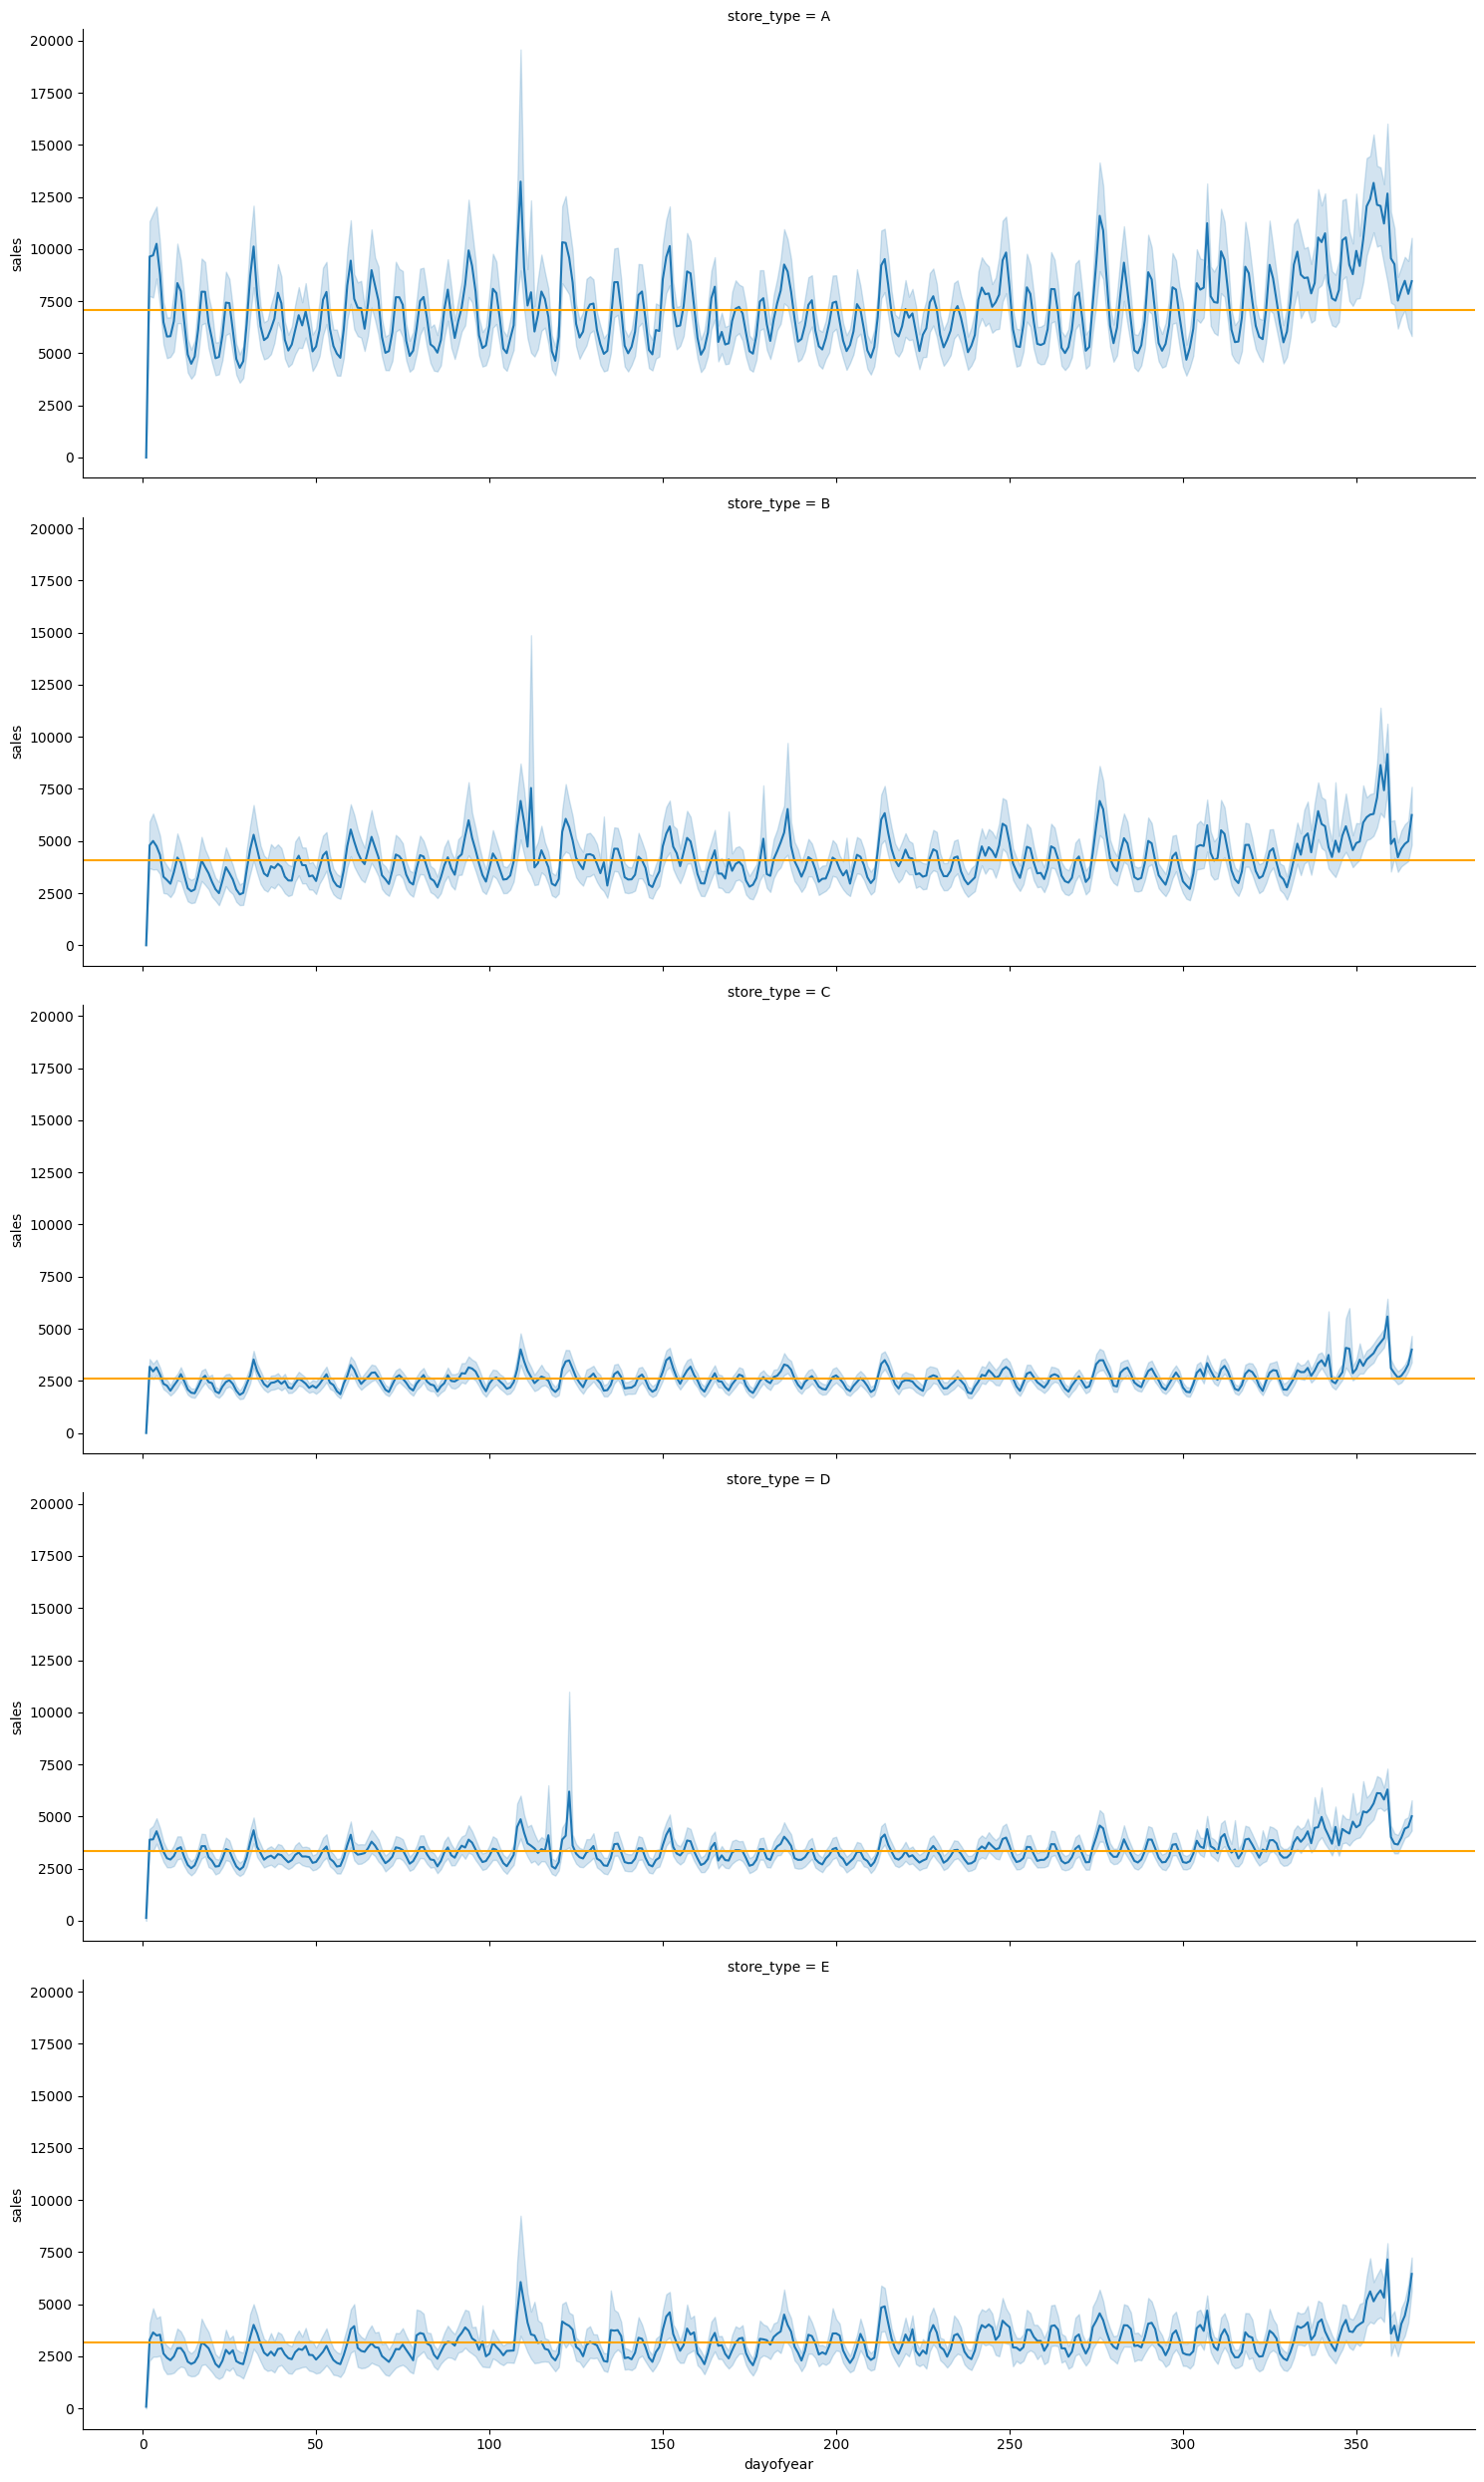

CPU times: user 39.8 s, sys: 413 ms, total: 40.3 s
Wall time: 39.7 s


In [4]:
%%time
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# > Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [5]:
%%time
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

CPU times: user 127 ms, sys: 11.1 ms, total: 138 ms
Wall time: 137 ms


,sum,std
family,,
GROCERY I,6.948780e+07,4128.244862
BEVERAGES,4.980825e+07,3473.010256
PRODUCE,3.527928e+07,3683.801989
CLEANING,1.832562e+07,1000.936294
DAIRY,1.613206e+07,940.274508
POULTRY,9.231635e+06,575.024603
BREAD/BAKERY,8.635977e+06,497.575158
MEATS,7.827470e+06,448.563508
PERSONAL CARE,5.184757e+06,350.195670


# 🤖Model

# > Pipes

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att, storetype, oilprice, holidays):
        self.att = att
        self.storetype = storetype
        self.oilprice = oilprice
        self.holidays = holidays
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = cleanData(X, self.storetype, self.oilprice, self.holidays) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion', 'weeknum', 'oil_price', 'holidays'], store_type, oil_price, holidays))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['weekname', 'month', 'store_nbr', 'store_type'], store_type, oil_price, holidays))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

In [7]:
%%time
pipe.fit(train)
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

CPU times: user 22.7 s, sys: 782 ms, total: 23.5 s
Wall time: 23.4 s


FeatureUnion(transformer_list=[('numeric',
                                Pipeline(steps=[('dataselect',
                                                 DataSelect(att=['onpromotion',
                                                                 'weeknum',
                                                                 'oil_price',
                                                                 'holidays'],
                                                            holidays={Timestamp('2012-03-02 00:00:00'): 1,
                                                                      Timestamp('2012-04-01 00:00:00'): 1,
                                                                      Timestamp('2012-04-12 00:00:00'): 1,
                                                                      Timestamp('2012-04-14 00:00:00'): 1,
                                                                      Timestamp('2012-04-21 00:00:00'): 1,
                                                                      Timestamp('2012-05-12 00:00:00'): 1,...
                                                                      Timestamp('2013-02-11 00:00:00'): 0.010308215647871353, ...},
                                                            storetype={1: 'D',
                                                                       2: 'D',
                                                                       3: 'D',
                                                                       4: 'D',
                                                                       5: 'D',
                                                                       6: 'D',
                                                                       7: 'D',
                                                                       8: 'D',
                                                                       9: 'B',
                                                                       10: 'C',
                                                                       11: 'B',
                                                                       12: 'C',
                                                                       13: 'C',
                                                                       14: 'C',
                                                                       15: 'C',
                                                                       16: 'C',
                                                                       17: 'C',
                                                                       18: 'B',
                                                                       19: 'C',
                                                                       20: 'B',
                                                                       21: 'B',
                                                                       22: 'C',
                                                                       23: 'D',
                                                                       24: 'D',
                                                                       25: 'D',
                                                                       26: 'D',
                                                                       27: 'D',
                                                                       28: 'E',
                                                                       29: 'E',
                                                                       30: 'C', ...})),
                                                ('encoder',
                                                 OneHotEncoder(handle_unknown='ignore',
                                                               sparse_output=False))]))])

# > Baseline

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def trainModels(d):
    ms = {}
    for member in d['family'].unique():
        trn = d.loc[d['family'] == member]
        x_val = pipe.transform(trn)
        y_val = trn[target]
        model = LinearRegression()
        model.fit(x_val, y_val)
        ms[member] = model
        
    return ms

def makePredictions(d, mod):
    pr = []
    for member in d['family'].unique():
        trn = d.loc[d['family'] == member]
        x_val = pipe.transform(trn)
        pr.append(pd.Series(mod[member].predict(x_val), index=trn.index))
    return pd.concat(pr)

In [9]:
%%time
models = trainModels(train)

CPU times: user 58.3 s, sys: 9.89 s, total: 1min 8s
Wall time: 44 s


# > Residuals. Make orange closer to blue dots.

In [10]:
g = train
elm = {}
for f in g['family'].unique():
    a = g.loc[train['family'] == f]
    elm[f] = np.sqrt(
        -cross_val_score(
            models[f]
            , pipe.transform(a)
            , a[target]
            , scoring='neg_mean_squared_error'
        ).mean())

pd.Series(elm).sort_values(ascending=False)

GROCERY I                     1699.266189
PRODUCE                       1620.245925
BEVERAGES                     1353.163745
MEATS                          402.236570
CLEANING                       401.851312
FROZEN FOODS                   286.109842
DAIRY                          283.772169
POULTRY                        187.621175
HOME CARE                      187.006432
BREAD/BAKERY                   186.123881
PERSONAL CARE                  144.203175
DELI                           116.980135
LIQUOR,WINE,BEER                99.981597
EGGS                            95.647629
PREPARED FOODS                  38.766746
HOME AND KITCHEN I              35.154442
HOME AND KITCHEN II             32.531384
GROCERY II                      22.960394
CELEBRATION                     16.545804
SCHOOL AND OFFICE SUPPLIES      12.778243
SEAFOOD                         12.515122
LADIESWEAR                      12.035133
PLAYERS AND ELECTRONICS          9.158737
LINGERIE                         8

In [11]:
g = train
elm = {}
for f in g['family'].unique():
    a = g.loc[train['family'] == f]
    elm[f] = np.sqrt(
        -cross_val_score(
            models[f]
            , pipe.transform(a)
            , a[target]
            , scoring='neg_mean_squared_error'
        ).mean())

pd.Series(elm).sort_values(ascending=False)

GROCERY I                     1699.266189
PRODUCE                       1620.245925
BEVERAGES                     1353.163745
MEATS                          402.236570
CLEANING                       401.851312
FROZEN FOODS                   286.109842
DAIRY                          283.772169
POULTRY                        187.621175
HOME CARE                      187.006432
BREAD/BAKERY                   186.123881
PERSONAL CARE                  144.203175
DELI                           116.980135
LIQUOR,WINE,BEER                99.981597
EGGS                            95.647629
PREPARED FOODS                  38.766746
HOME AND KITCHEN I              35.154442
HOME AND KITCHEN II             32.531384
GROCERY II                      22.960394
CELEBRATION                     16.545804
SCHOOL AND OFFICE SUPPLIES      12.778243
SEAFOOD                         12.515122
LADIESWEAR                      12.035133
PLAYERS AND ELECTRONICS          9.158737
LINGERIE                         8

In [12]:
g = test
elm = {}
for f in g['family'].unique():
    a = g.loc[g['family'] == f]
    elm[f] = np.sqrt(
        -cross_val_score(
            models[f]
            , pipe.transform(a)
            , a[target]
            , scoring='neg_mean_squared_error'
        ).mean())

pd.Series(elm).sort_values(ascending=False)

BEVERAGES                     2.239541e+15
GROCERY I                     1.964412e+15
DAIRY                         1.705302e+15
POULTRY                       1.515154e+15
BREAD/BAKERY                  1.436228e+15
CLEANING                      1.287246e+15
PERSONAL CARE                 1.137007e+15
FROZEN FOODS                  8.634762e+14
PREPARED FOODS                8.278000e+14
PRODUCE                       7.557916e+14
EGGS                          5.982613e+14
LIQUOR,WINE,BEER              4.282681e+14
MEATS                         3.386431e+14
GROCERY II                    3.159354e+14
HOME CARE                     2.847962e+14
SCHOOL AND OFFICE SUPPLIES    1.885375e+14
HOME AND KITCHEN I            1.641508e+14
HOME AND KITCHEN II           1.436634e+14
DELI                          1.018522e+14
SEAFOOD                       7.782167e+13
LADIESWEAR                    6.805593e+13
PLAYERS AND ELECTRONICS       5.166580e+13
MAGAZINES                     4.848541e+13
PET SUPPLIE

CPU times: user 746 ms, sys: 354 ms, total: 1.1 s
Wall time: 493 ms


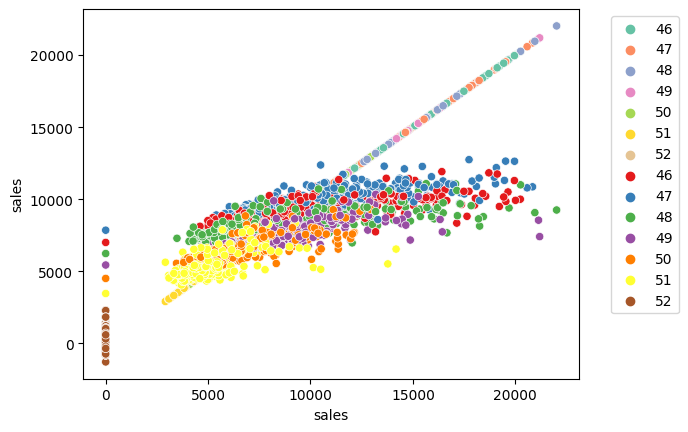

In [13]:
%%time
g = train.query('family == "GROCERY I"').copy()
g = g.query('store_type == "A"')
g = g.query('year == 2016')
g = g.query('store_nbr not in (45, 44, 1,2,3,4,5,9,7,12,20)')
g
sns.scatterplot(g, x=target, y=target, hue='store_nbr', palette='Set2');
sns.scatterplot(g, x=target, y=makePredictions(g, models), hue='store_nbr', palette='Set1');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# sns.scatterplot(x=g[target],y=makePredictions(g, models), hue='year');
## improve this. you are in the right direction.

CPU times: user 580 ms, sys: 275 ms, total: 855 ms
Wall time: 376 ms


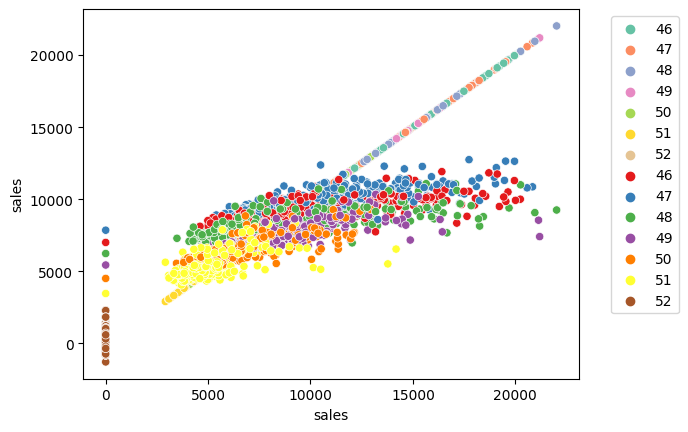

In [14]:
%%time
g = train.query('family == "GROCERY I"').copy()
g = g.query('store_type == "A"')
g = g.query('year == 2016')
g = g.query('store_nbr not in (45, 44, 1,2,3,4,5,9,7,12,20)')
g
sns.scatterplot(g, x=target, y=target, hue='store_nbr', palette='Set2');
sns.scatterplot(g, x=target, y=makePredictions(g, models), hue='store_nbr', palette='Set1');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# sns.scatterplot(x=g[target],y=makePredictions(g, models), hue='year');
## improve this. you are in the right direction.

# > Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

CPU times: user 48.1 s, sys: 541 ms, total: 48.6 s
Wall time: 47.9 s


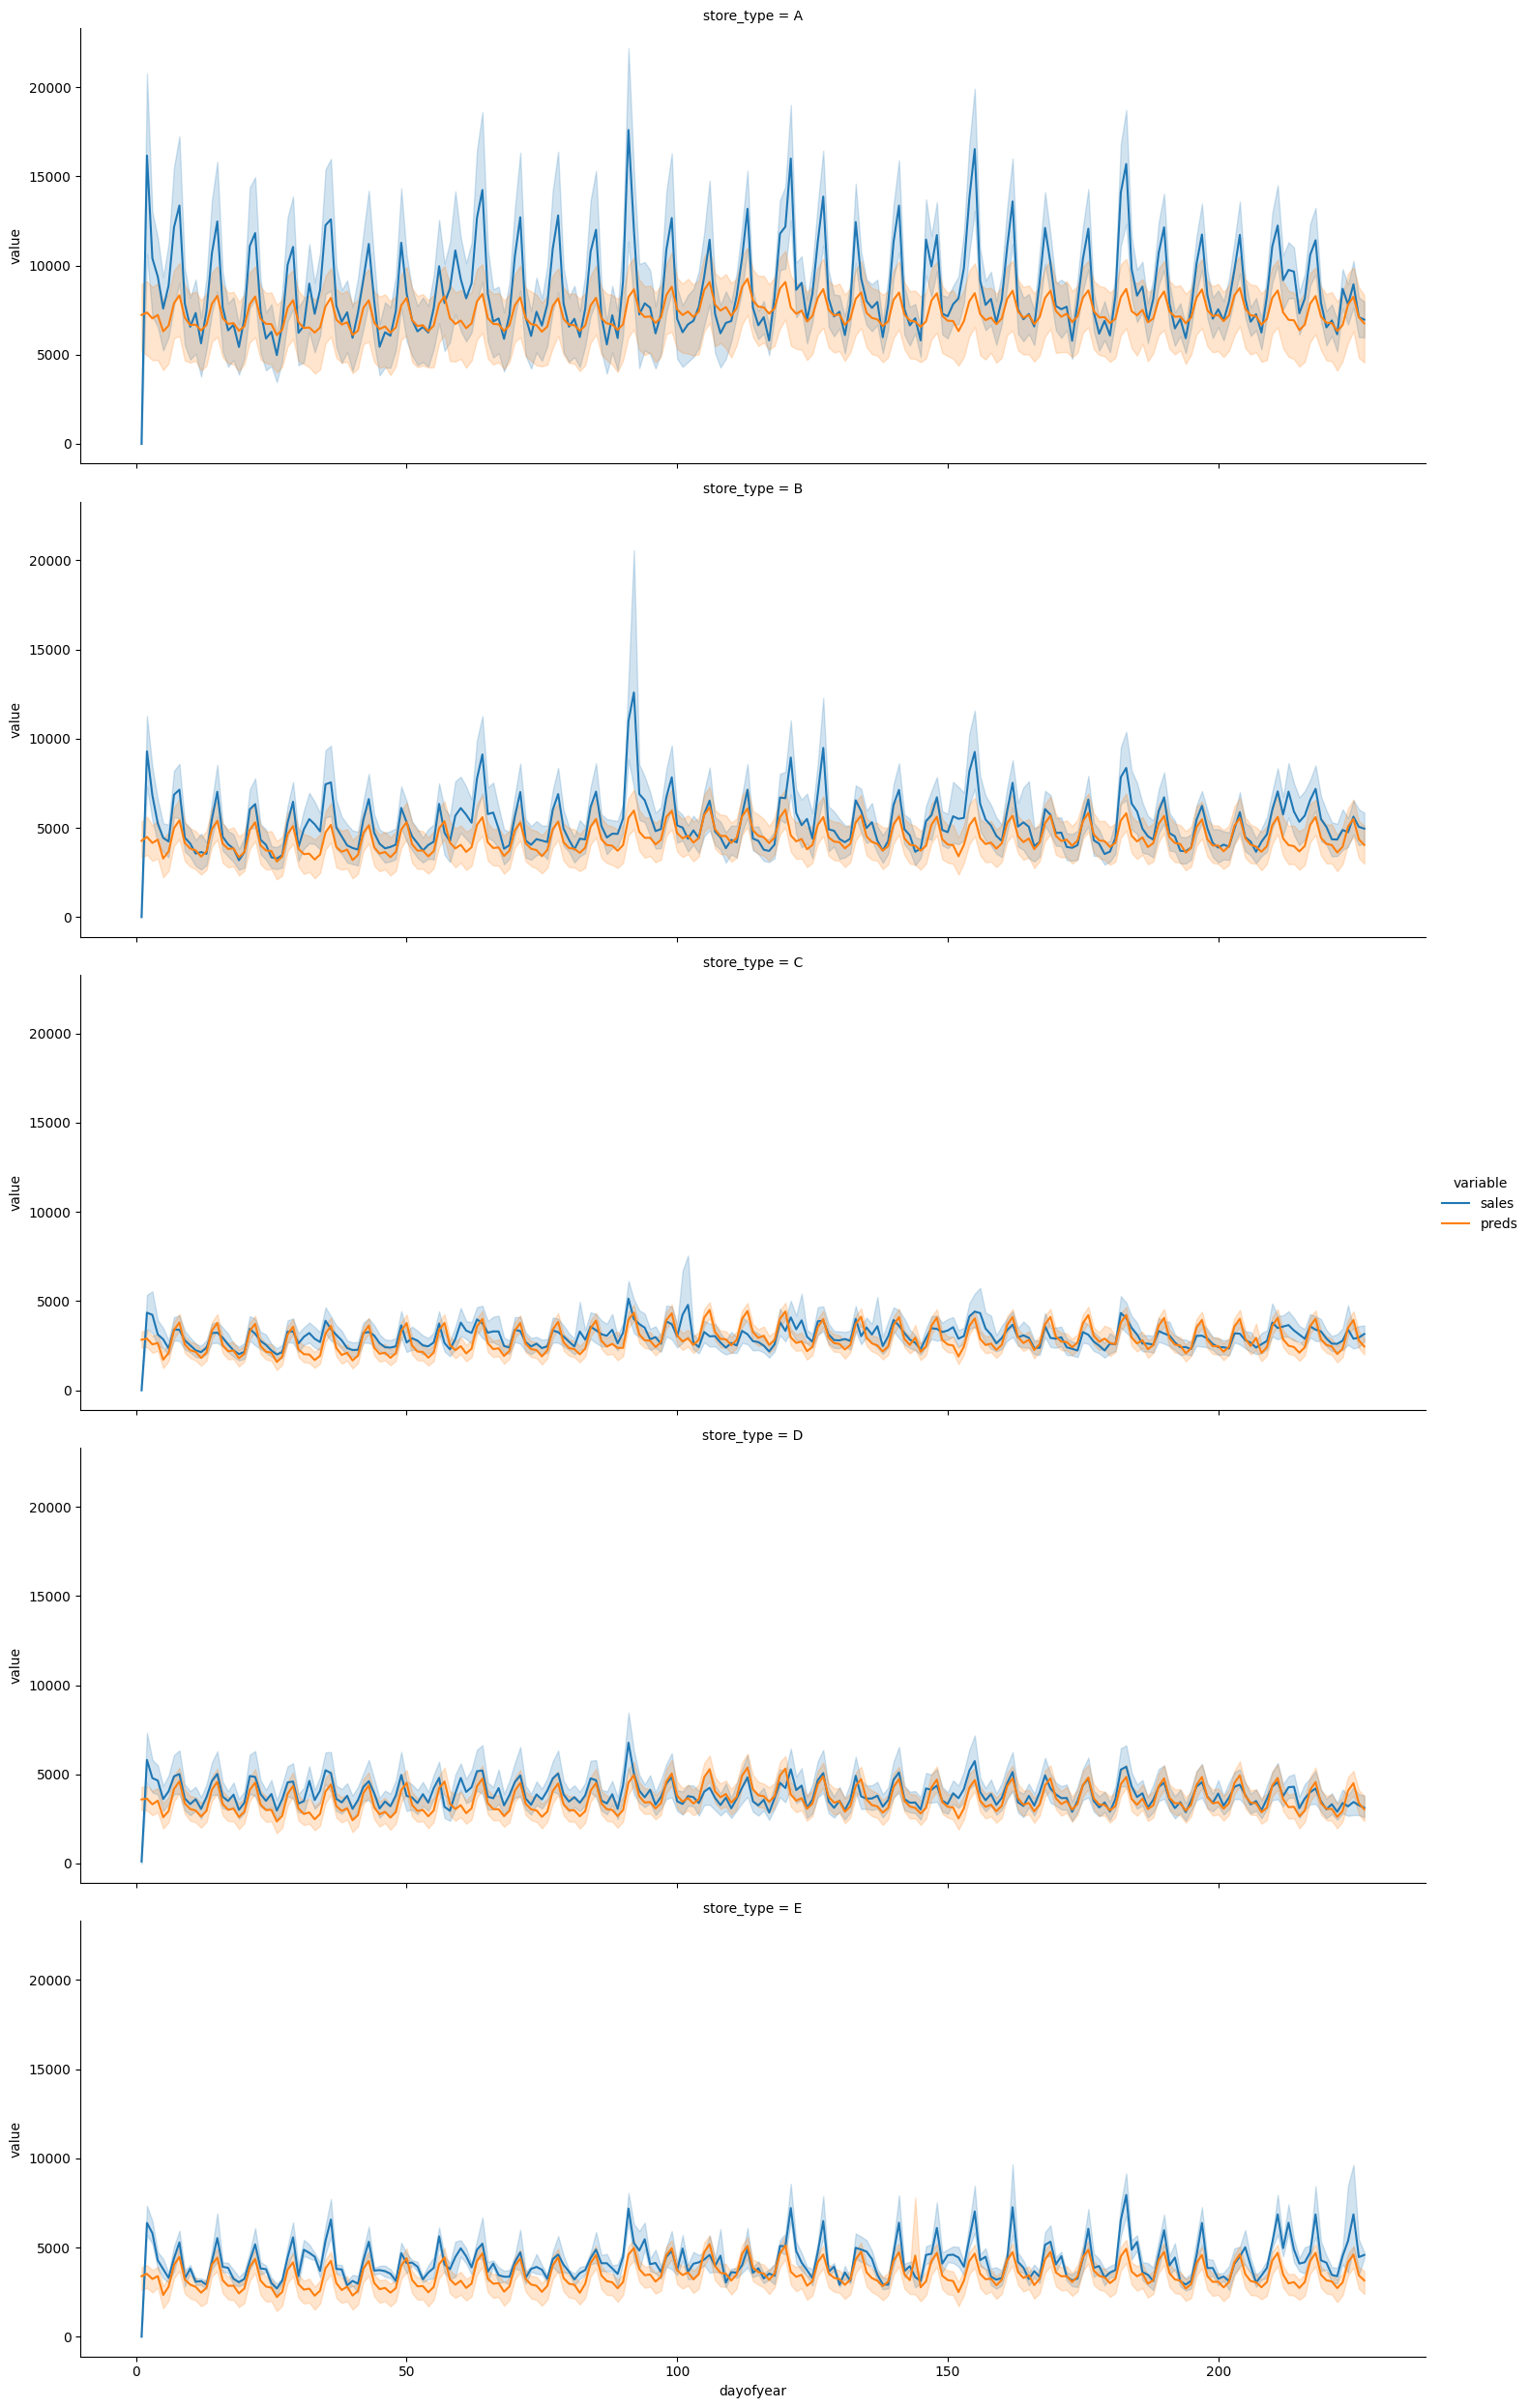

In [15]:
%%time
g = test.copy()
g = g.query('family == "GROCERY I"')
g['preds'] = makePredictions(g, models)

g = g[['store_type', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_type', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='store_type'
            , row_order=list('ABCDE')
            , kind='line', aspect=3);

CPU times: user 1min 17s, sys: 735 ms, total: 1min 18s
Wall time: 1min 17s


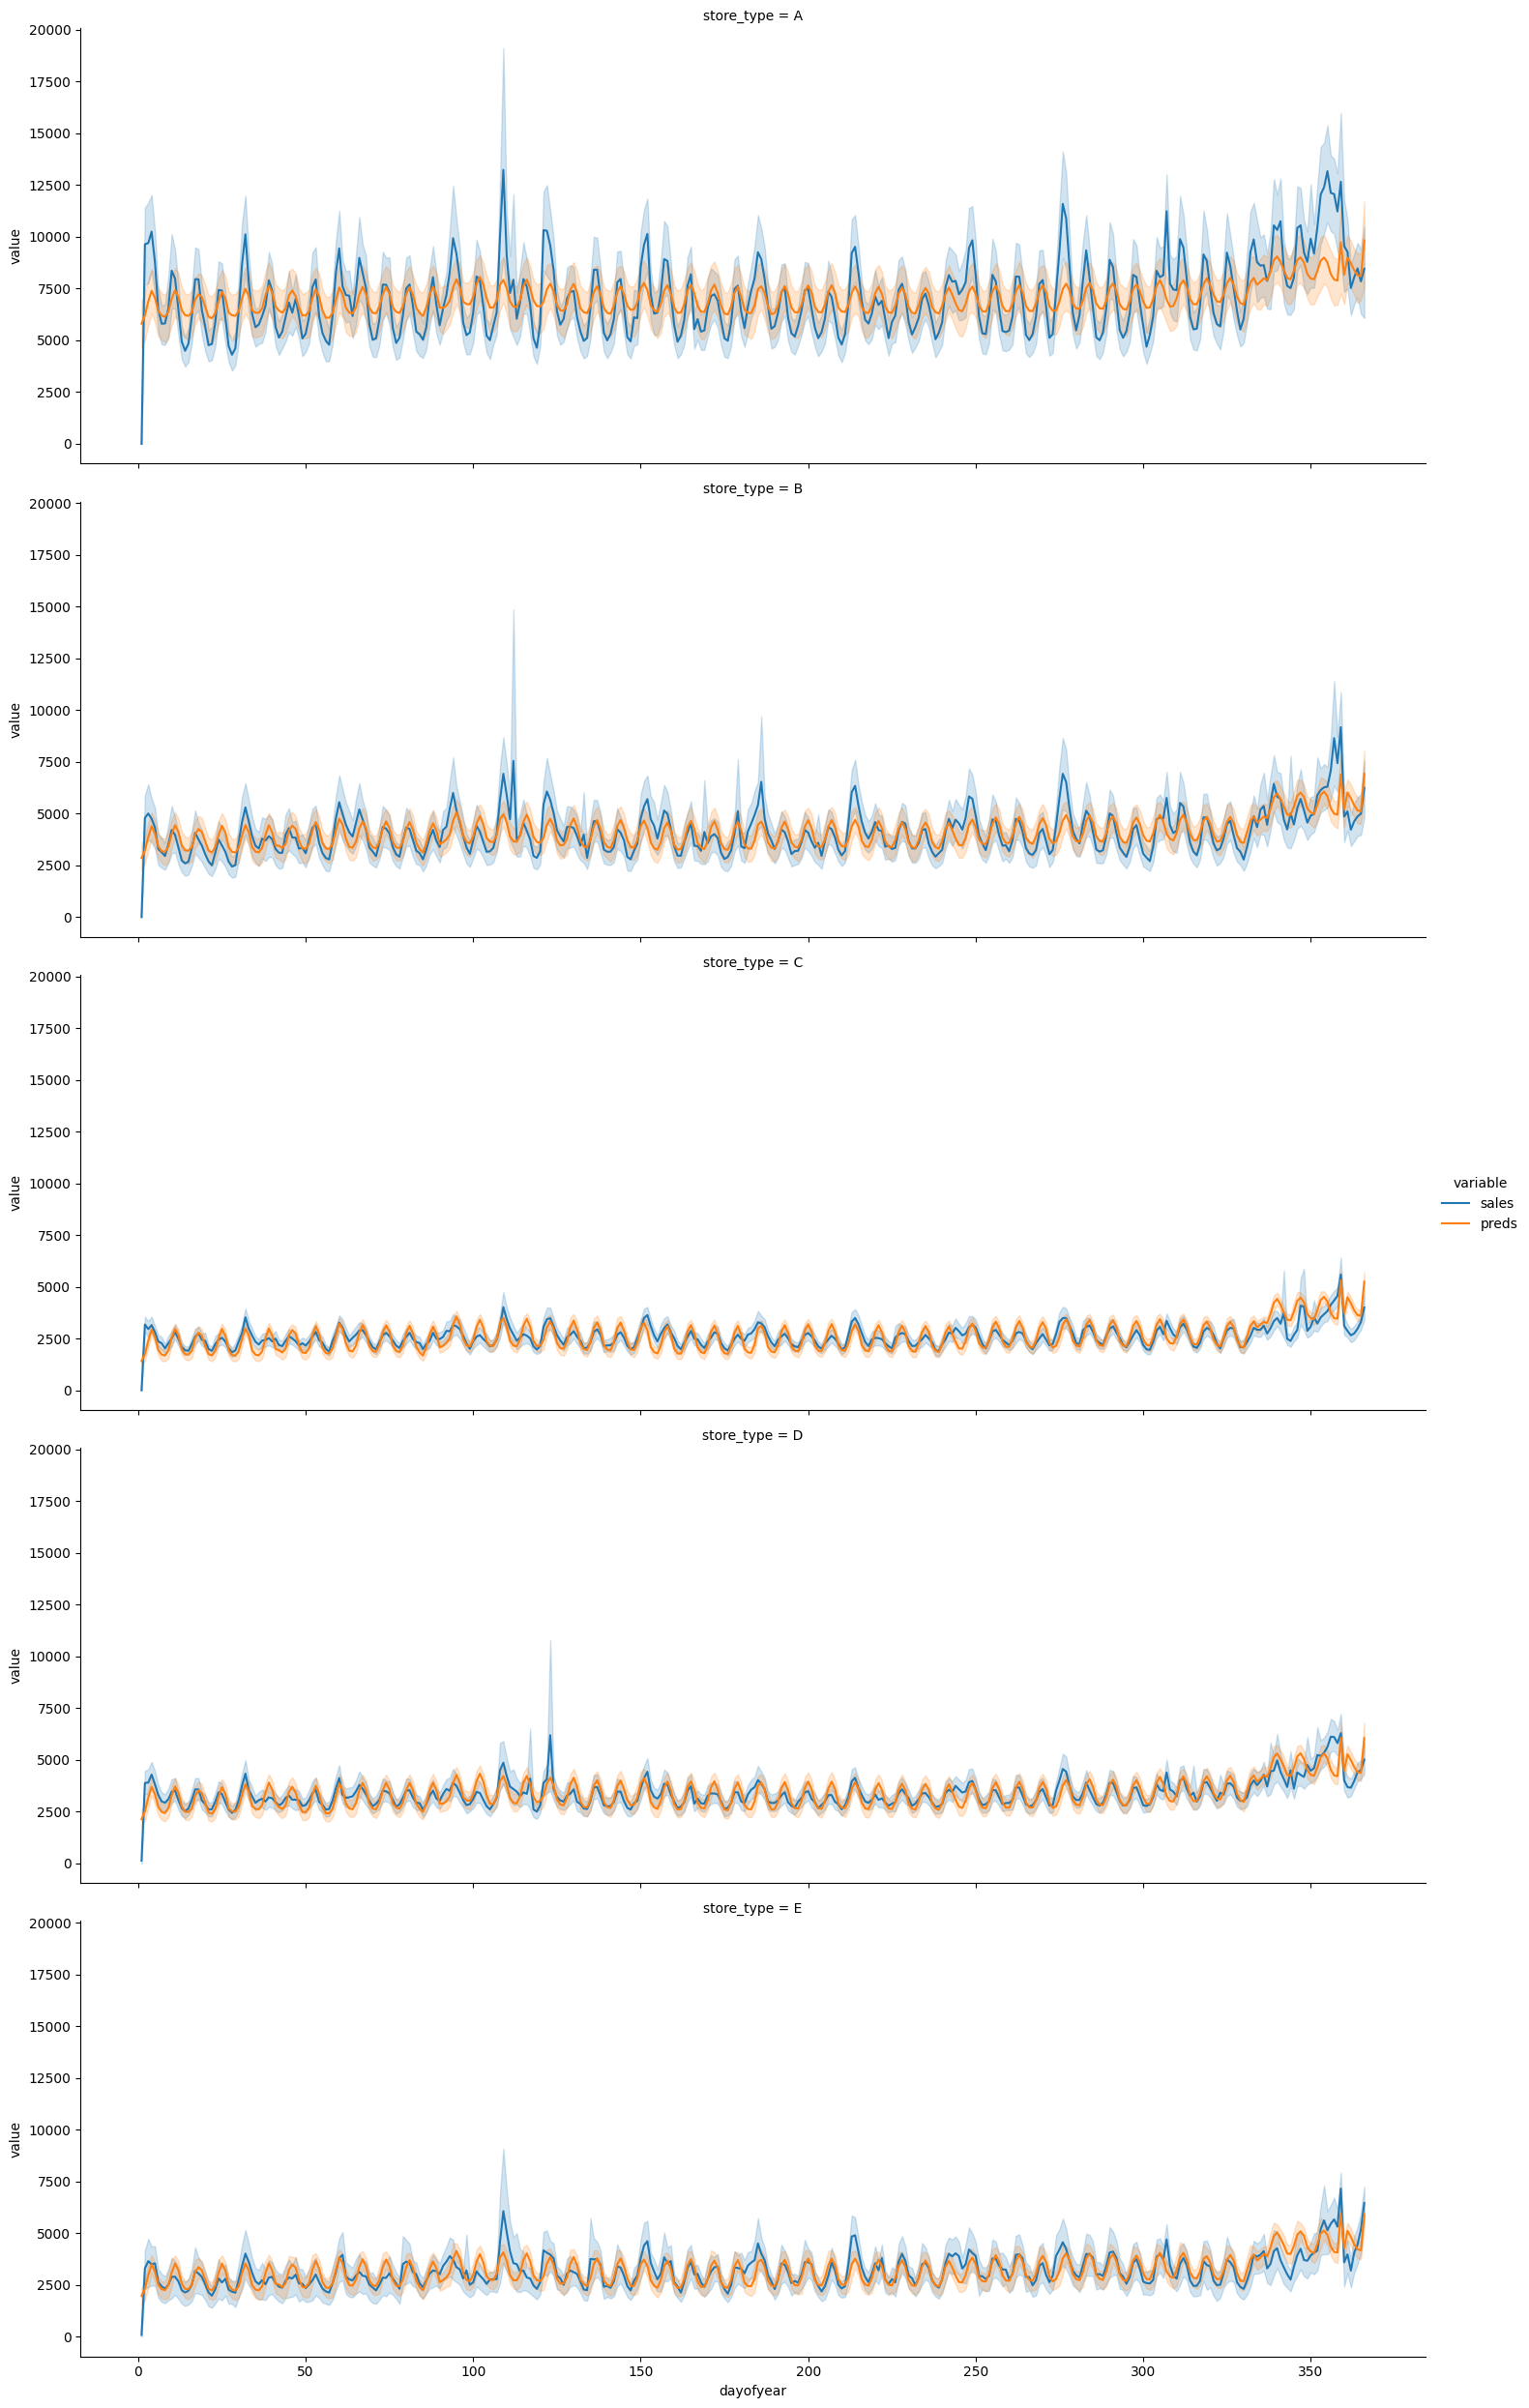

In [16]:
%%time
g = train.copy()
g = g.query('family == "GROCERY I"')
g['preds'] = makePredictions(g, models)

g = g[['store_type', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_type', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='store_type'
            , row_order=list('ABCDE')
            , kind='line', aspect=3);

CPU times: user 15.6 s, sys: 416 ms, total: 16.1 s
Wall time: 15.4 s


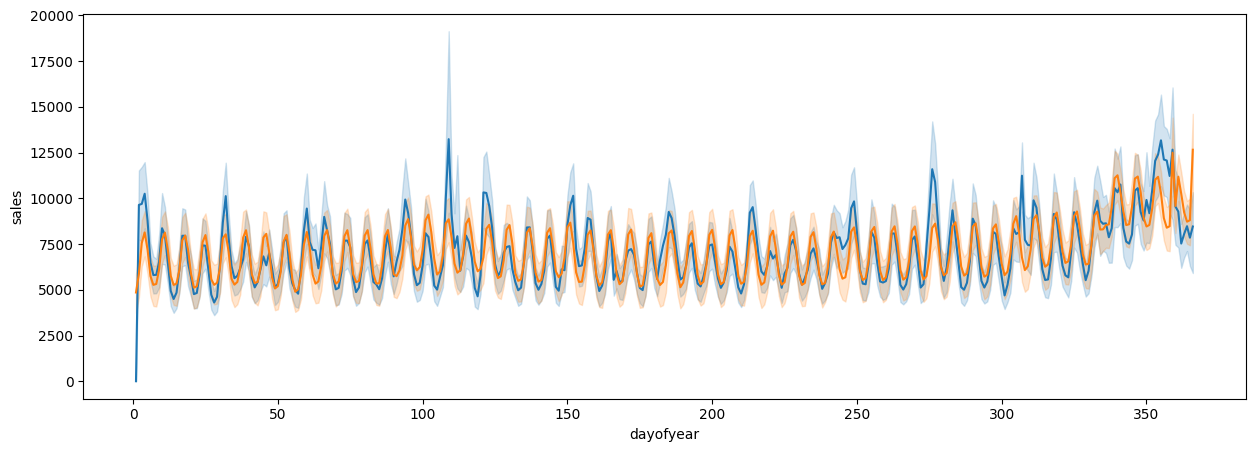

In [17]:
%%time
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

# > Questioning the zeros
Do I train the model without the zeros? Do I train each family and cluster separately?
Yes, you need to train the model for each family. And the zeros matter.

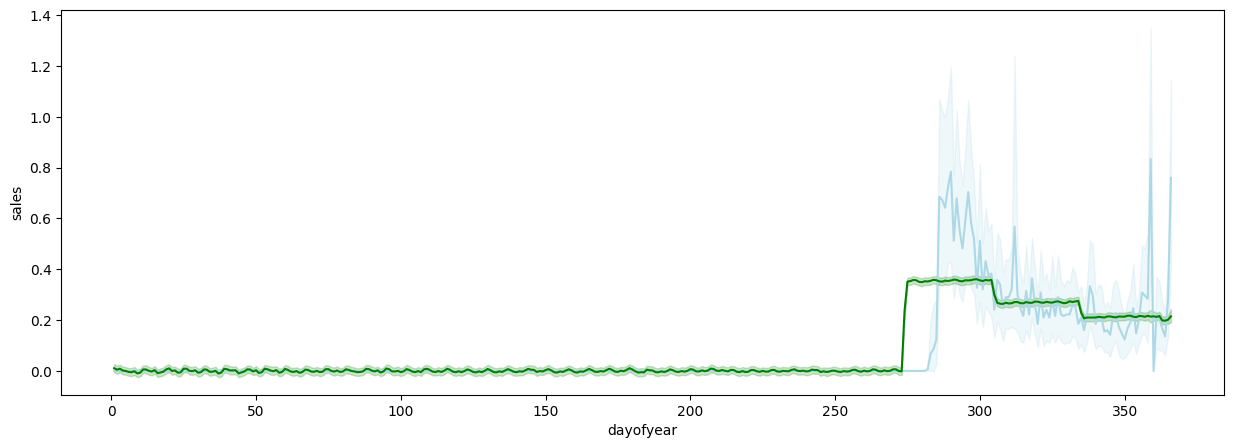

In [18]:
g = train.copy()
g = g.query('family == "BOOKS"')
g['preds'] = makePredictions(g, models)
# g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
# g_pp = pipe.transform(g)
# g_model = LinearRegression()
# g_model.fit(g_pp, g[target])
# g['preds_nonzero'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
# sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='orange');
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='green');

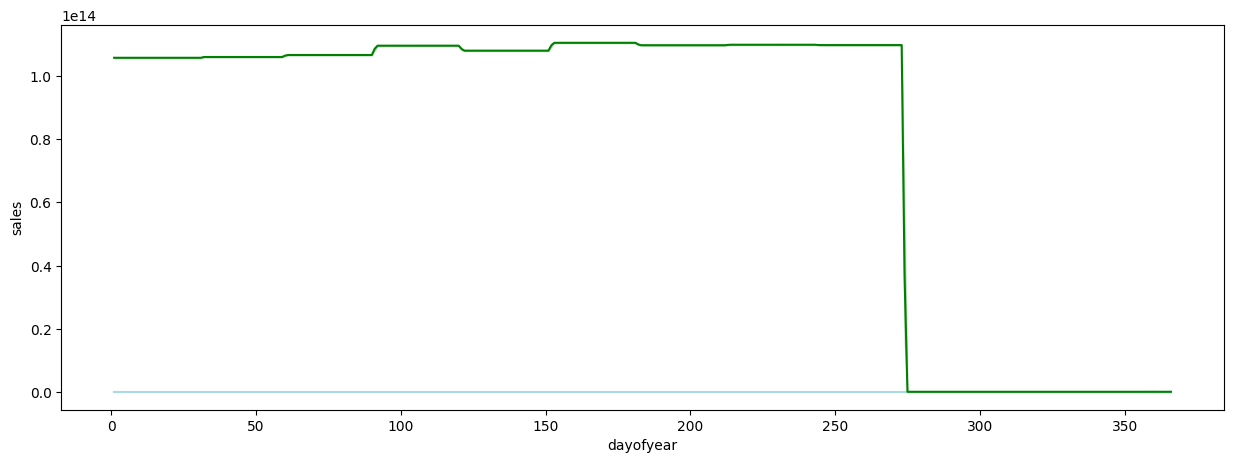

In [19]:
g = train.copy()
g = g.query('family == "BOOKS"')
g = g.query('store_type == "A"')

g_tr = g.loc[g[target] != 0]
g_model = LinearRegression()
g_model.fit(pipe.transform(g_tr), g_tr[target])
g['preds'] = g_model.predict(pipe.transform(g))

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='green');

# > Submission

In [20]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
pd.DataFrame({
    'id': samp['id']
    , 'sales': makePredictions(samp, models)
}).to_csv('submission.csv', index=False)

In [21]:
# # # %load_ext autoreload
# # # %autoreload 2
# import datawarehouse as dw
# dw.uploadData(export, "storesales_v04")

# %%time
# train['preds'] = makePredictions(train, models)
# train['dataset'] = 'train'
# test['preds'] = makePredictions(test, models)
# test['dataset'] = 'test'

# samp = cleanData(samp, store_type, oil_price)
# samp['preds'] = makePredictions(samp, models)
# samp['dataset'] = 'sample'
# export = pd.concat([train, test, samp], axis=0)